In [453]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

from glob import glob
from os.path import join
from scipy import interpolate

import itertools
import time
import sys  

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

vol = '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/'
# vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Thu Jul 16 19:01:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   33C    P8    14W / 250W |   2014MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                      

# Background

**Question:** What is the temperature at the levels between the surface and altitude of the minimm equalibrium level?

---
# Data Loader

In [4]:
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2
ALTITUDE = 3

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= 1000 and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

In [5]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

fp = FloatProgress(min=0, max=(len(files)))
display(fp)

profiles = []
valid_profile_files = []

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        profile = np.concatenate((xar.pres.values.reshape(-1,1),
                                  xar.tdry.values.reshape(-1,1),
                                  xar.dp.values.reshape(-1,1),
                                  xar.alt.values.reshape(-1,1)), axis=1)
        profiles.append(profile)
        valid_profile_files.append(f)
    xar.close()
    fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

FloatProgress(value=0.0, max=27209.0)

time: 395.128, avg: 0.015 seconds


In [6]:
len(profiles), profiles[0].shape, profiles[-1].shape

(25460, (3574, 4), (2884, 4))

---
# Preprocess

## EL for All Profiles

In [7]:
is_valid = np.ones(len(profiles), dtype=bool)
els = np.zeros(len(profiles))
alts = np.zeros(len(profiles))

fp = FloatProgress(min=0, max=(len(profiles)))
display(fp)

s = time.time()
for i, profile in enumerate(profiles):
    sounding_dict = dict()
    sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = profile[:, PRESSURE]
    sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = profile[:, TEMPERATURE]
    sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = profile[:, DEWPOINT]
    try:
        el_p, _ = radiosonde_products.el(sounding_dict)
        if np.isnan(el_p):
            is_valid[i] = False
        else: 
            els[i] = el_p
            # altitude of pressure value at the EL
            alts[i] = profile[:, ALTITUDE][(np.abs(profile[:, PRESSURE] - el_p)).argmin()]
    except:
        is_valid[i] = False
        
    fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f} seconds')

FloatProgress(value=0.0, max=25460.0)

/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: divide by zero encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in multiply
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0


time: 3269.437 seconds


In [8]:
valid_els = els[is_valid]
print(f'{valid_els.shape}, mean: {valid_els.mean():.2f}, std: {valid_els.std():.2f}, max: {valid_els.max():.2f}, min: {valid_els.min():.2f}')

(11529,), mean: 386.37, std: 269.25, max: 991.20, min: 71.80


In [9]:
alts_el = alts[is_valid]
print(f'{alts_el.shape}, mean: {alts_el.mean():.2f}, std: {alts_el.std():.2f}, max: {alts_el.max():.2f}, min: {alts_el.min():.2f}')
print(f'max EL alt: {alts_el[valid_els.argmax()]:.2f}, min EL alt: {alts_el[valid_els.argmin()]:.2f}')

(11529,), mean: 9017.33, std: 4621.06, max: 19374.00, min: 314.80
max EL alt: 315.00, min EL alt: 19374.00


In [10]:
# np.save(vol + '../profiles-alt.npy', np.array(profiles))
# with open(vol + '../profiles-alt-files.txt', 'w') as f:
#     for item in valid_profile_files:
#         f.write("%s\n" % item)

In [79]:
# profiles = np.load(vol + '../profiles-alt.npy', allow_pickle=True)
# valid_profile_files = np.loadtxt(vol + '../profiles-alt-files.txt', dtype=str)

## Filter Profiles by $A_{el}$

In [ ]:
alt_el = 21_000. # slightly above the altitude of the minimum EL

In [94]:
is_valid = np.ones(len(profiles), dtype=bool)

# fp = FloatProgress(min=0, max=(len(profiles)))
# display(fp)

s = time.time()
for i, profile in enumerate(profiles):
    # does not reach the altitude of the minimum EL
    if profile[-1, ALTITUDE] < alt_el:
        is_valid[i] = False
    # fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f} seconds')

time: 0.045 seconds


In [95]:
valid_profile_files.shape, profiles.shape

((25460,), (25460,))

In [96]:
profiles = np.asarray(profiles)[is_valid]
valid_profile_files = np.asarray(valid_profile_files)[is_valid]
valid_profile_files.shape, profiles.shape

((23237,), (23237,))

In [97]:
print(f'Total of {valid_profile_files.shape[0]} / {len(files)} valid files')

Total of 23237 / 27209 valid files


##  Intopolate Values Between [0, $A_{el}$]

In [326]:
SONDE_PROFILE_DIMS = 2048

In [327]:
alt_s = profiles[0][0,ALTITUDE]
altitude_intervals = np.linspace(alt_s, alt_el, SONDE_PROFILE_DIMS)

In [328]:
def interpolate_to_height_intervals(alt, y, altitude_intervals):
    f = interpolate.interp1d(alt, y)
    return f(altitude_intervals)

In [329]:
interpolated_profiles = np.zeros((len(profiles), SONDE_PROFILE_DIMS, 4))
for i in range(len(profiles)):
    
    # remove duplicate values at surface level 
    alt_s = profiles[i][0, ALTITUDE]
    start_indx = 0
    for j in range(1, len(profiles[i][:, ALTITUDE])):
        if profiles[i][j, ALTITUDE] == alt_s:
            start_indx = j
        else:
            break
            
    p_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, PRESSURE], altitude_intervals)
    t_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, TEMPERATURE], altitude_intervals)
    td_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, DEWPOINT], altitude_intervals)
    
    interpolated_profiles[i] = np.concatenate(([p_n], [t_n], [td_n], [altitude_intervals])).T

In [330]:
interpolated_profiles.shape

(23237, 2048, 4)

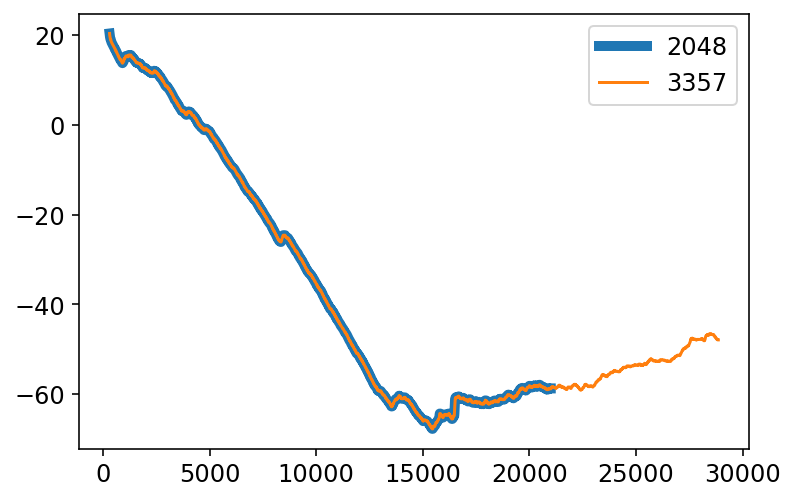

In [331]:
i = 2
plt.plot(interpolated_profiles[i, :, ALTITUDE], interpolated_profiles[i, :, TEMPERATURE], lw=5,
         label=str(len(interpolated_profiles[i, :, ALTITUDE])))
plt.plot(profiles[i][:, ALTITUDE], profiles[i][:, TEMPERATURE],
         label=str(len(profiles[i][:, ALTITUDE])))
plt.legend();

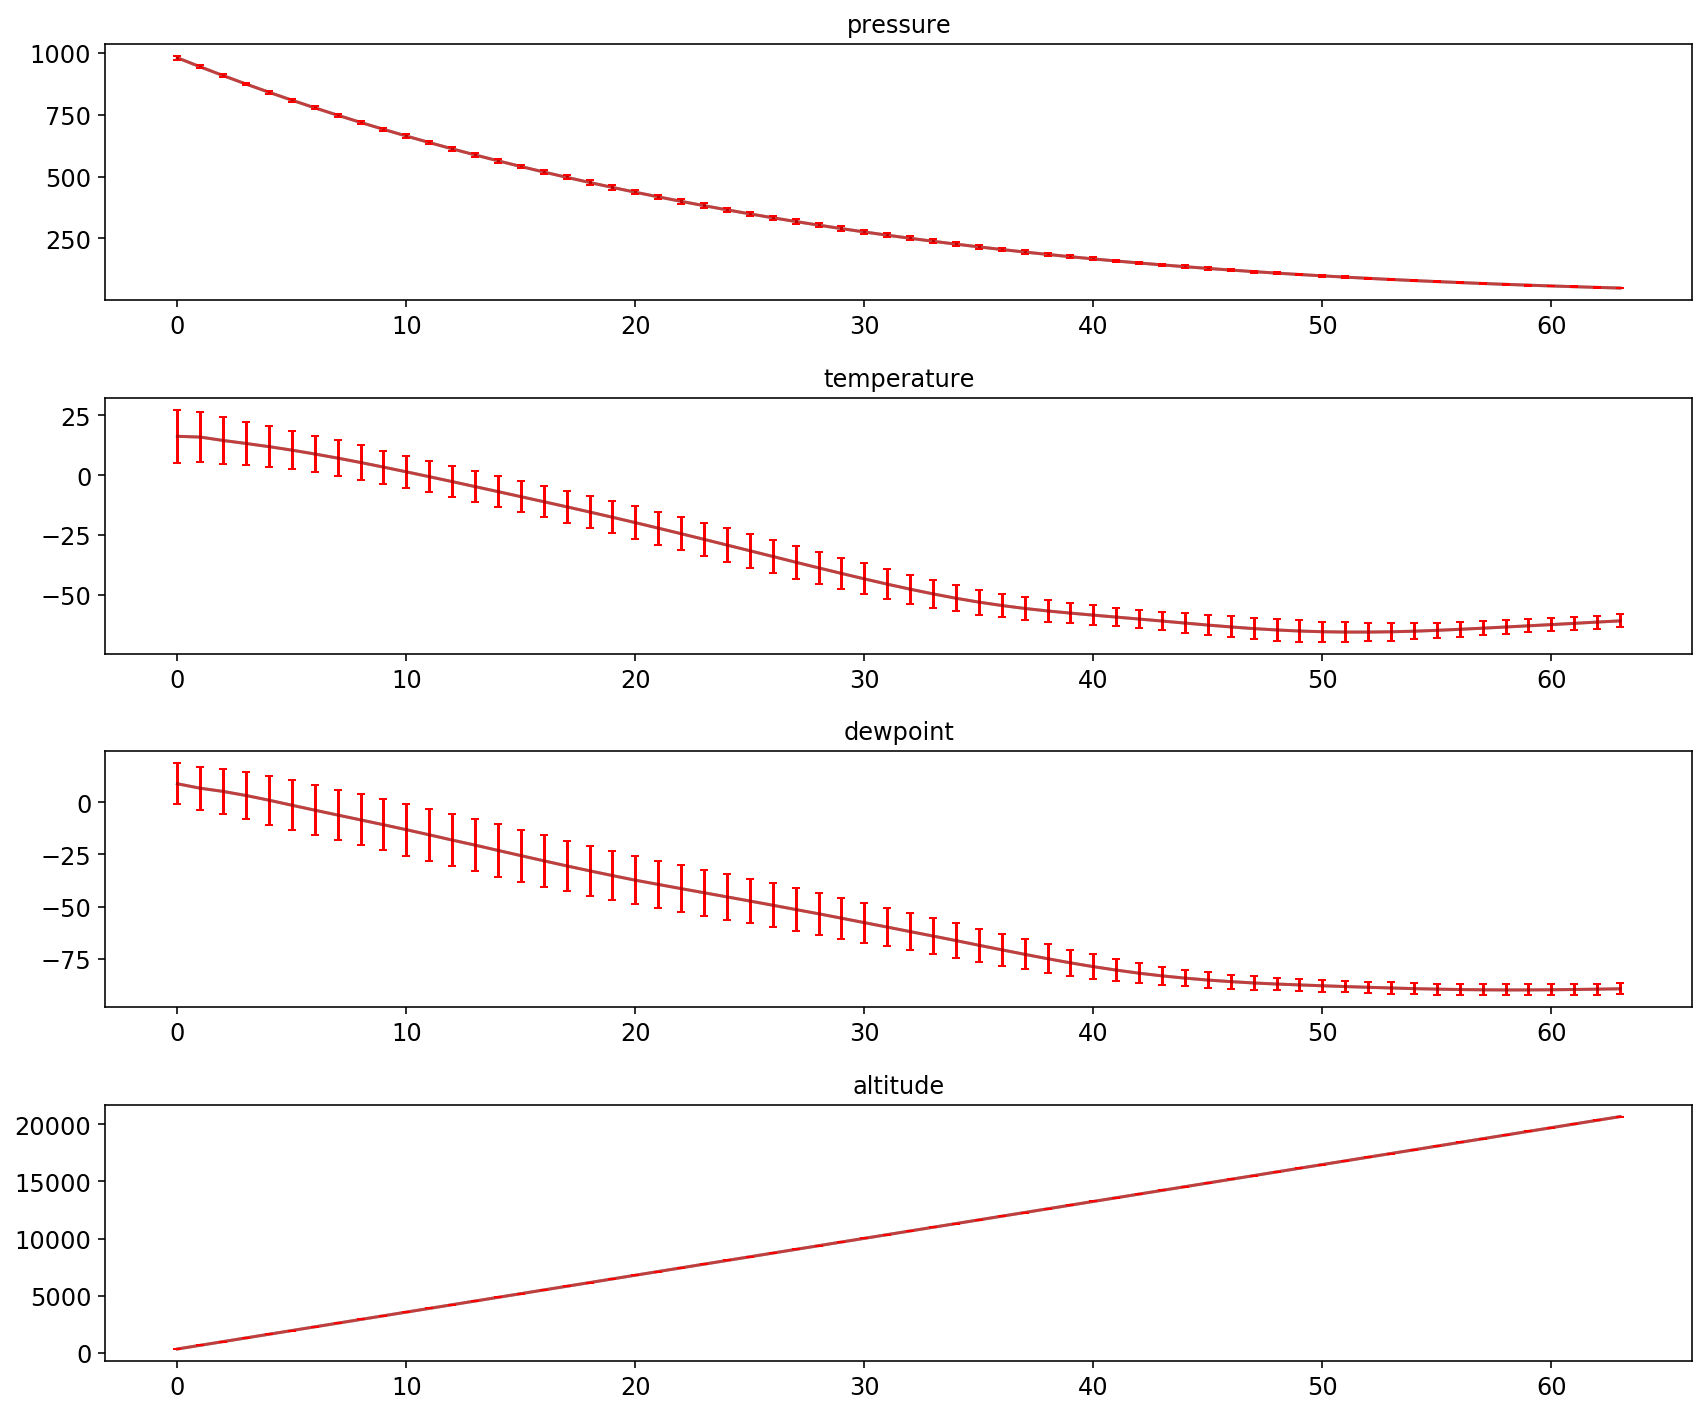

In [332]:
input_dims = [PRESSURE, TEMPERATURE, DEWPOINT, ALTITUDE]
labels = ['pressure', 'temperature', 'dewpoint', 'altitude']

fig, axs = plt.subplots(len(input_dims), figsize=(12, 10))
axs = axs.ravel()

for dim in input_dims:

    mu = np.mean(interpolated_profiles[:,:,dim], axis=0)[::32]
    std = np.std(interpolated_profiles[:,:,dim], axis=0)[::32]

    axs[dim].plot(mu, 'k', alpha=0.5)
    axs[dim].errorbar(np.arange(mu.shape[0]), mu, std, color='k', linestyle='None', capsize=2);

    mu = np.mean(interpolated_profiles[:,:,dim], axis=0)[::32]
    std = np.std(interpolated_profiles[:,:,dim], axis=0)[::32]

    axs[dim].plot(mu, 'r', alpha=0.5, label='train')
    axs[dim].errorbar(np.arange(mu.shape[0]), mu, std, color='r', linestyle='None', capsize=2);
    axs[dim].set_title(labels[dim])
    
fig.tight_layout();               

In [130]:
# np.save(vol + '../profiles-alt-processed.npy', interpolated_profiles)
# with open(vol + '../profiles-alt-files-processed.txt', 'w') as f:
#     for item in valid_profile_files:
#         f.write("%s\n" % item)

---
# Basic CAE

In [510]:
def plot_results(nnet, X, T, index=0, loss=True):

    P = X[index,:,PRESSURE]
        
    sounding_dict_for_metpy = dict()
    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]
    
    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)
    if loss:
        fig, ax = plt.subplots(1, figsize=(8, 4))

        ax.plot(nnet.history['loss'], label='train')
        ax.plot(nnet.history['val_loss'], label='val')
        ax.legend();
    
def mean_pressure_errors(nnet, X, T):
    error = np.abs((nnet.use(X) - T))
    pressures = X[:,:,PRESSURE]
    # Create linearly spaced bins from the min to max pressure
    bins = np.linspace(pressures.min(), pressures.max() + 1, pressures.shape[1])
    # Indicies of where which bin pressure values belong
    pressure_bin_indicies = np.digitize(pressures, bins)
    
    mean_error = np.zeros(bins.size)
    # Mean error corresponding to each bin of pressure levels
    for bin_index in range(bins.size):
        vals = error[pressure_bin_indicies == bin_index]
        mean = np.mean(vals) if vals.size > 0 else 0
        mean_error[bin_index] = mean
        
    # trim mean 0's from ends
    s = 0
    for i in range(mean_error.size):
        if mean_error[i] != 0:
            s = i
            break
    e = mean_error.size
    for i in range(mean_error.size-1, 0, -1):
        if mean_error[i] != 0:
            e = i
            break

    mean_error = mean_error[s:e+1]
    bins = bins[s:e+1]
    
    return mean_error, bins

def plot_altitude_rmse(nnet, X, T):
    alt_s = interpolated_profiles[0, 0, ALTITUDE]
    altitude_intervals = np.linspace(alt_s, alt_el, interpolated_profiles.shape[1])

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs = axs.ravel()
    Y = nnet.use(X)
    rmse = np.sqrt((np.mean((Y - T)**2, axis=0)))
    mean_rmse = ml.rmse(Y, T)

    axs[0].plot(altitude_intervals, rmse)
    axs[0].hlines(mean_rmse, altitude_intervals[0], altitude_intervals[-1],
                  'k', '--', label=f'{mean_rmse:.3f}')
    
    surface_error = 100
    axs[1].plot(altitude_intervals[:surface_error], rmse[:surface_error])
    axs[1].hlines(mean_rmse, altitude_intervals[:surface_error][0], 
                  altitude_intervals[:surface_error][-1], 'k', '--')

    axs[0].set_xlabel('Altitude (m)')
    axs[1].set_xlabel('Altitude (m)')
    axs[0].set_ylabel('RMSE (C)')
    axs[0].legend();

In [333]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(interpolated_profiles, interpolated_profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((18590, 2048, 3), (18590, 2048), (4647, 2048, 3), (4647, 2048))

In [468]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(3, 1)]*4,
                                   Ttrain.shape[1], activation='relu',
                                   n_hidden_dims=512, seed=1234)
# nnet.model.summary()
nnet.train(Xtrain, Ttrain, 25, 256, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.32914
epoch: 5, loss: 0.02154
epoch: 10, loss: 0.01121
epoch: 15, loss: 0.00877
epoch: 20, loss: 0.00692
epoch: 24, loss: 0.00606
finished!


ConvolutionalAutoEncoder((2048, 3), [4, 4, 8, 8], [(3, 1), (3, 1), (3, 1), (3, 1)], 2048)
  Final objective value is 0.00606 in 71.4295 seconds.

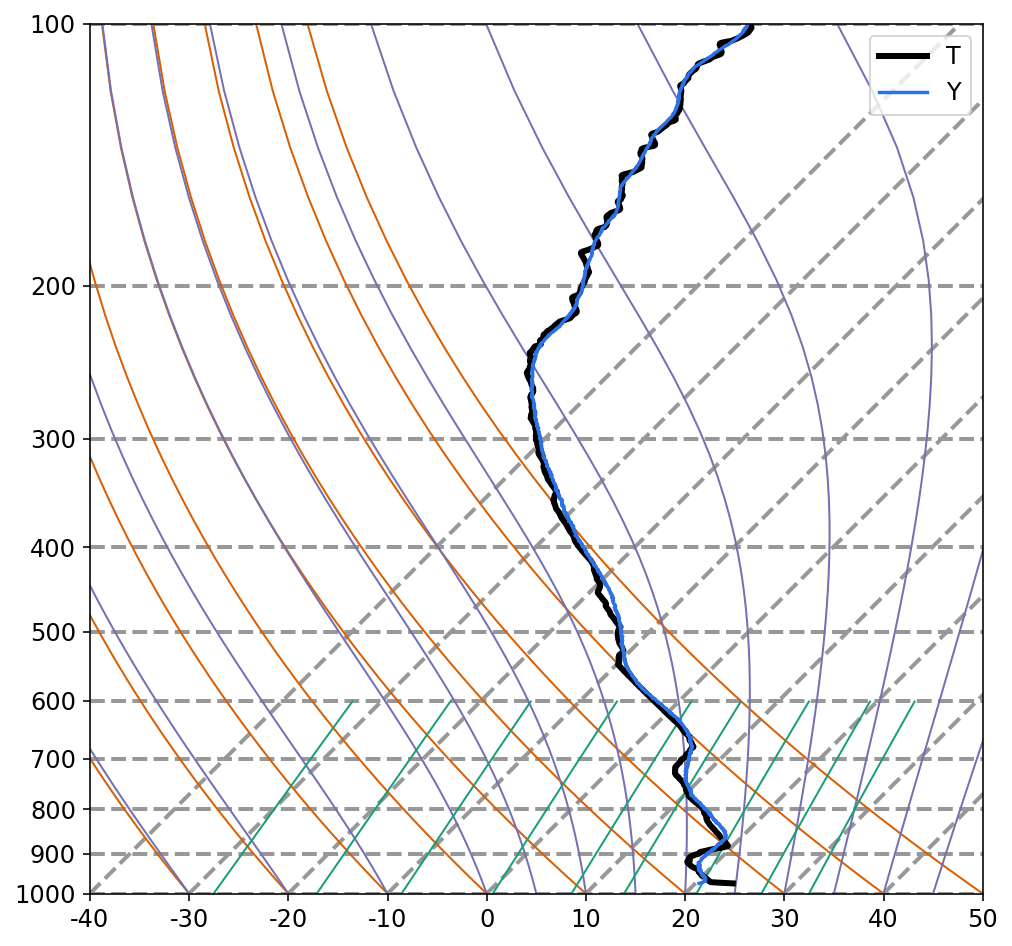

In [469]:
plot_results(nnet, Xtest, Ttest, 25, loss=False)

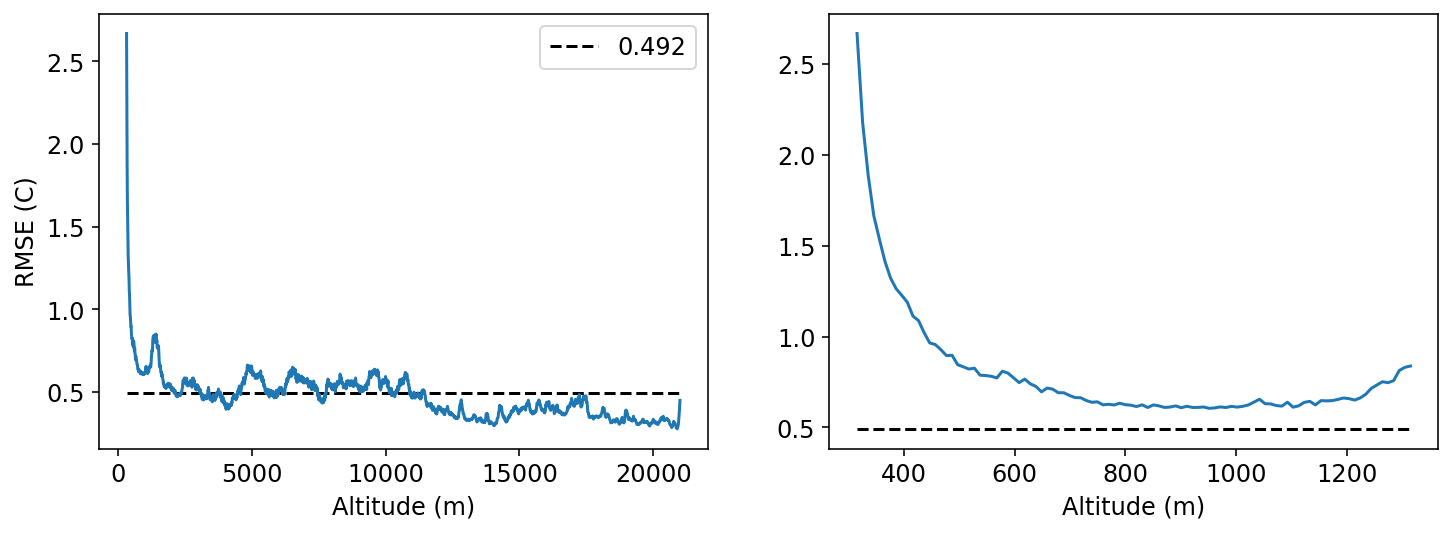

In [470]:
plot_altitude_rmse(nnet, Xtest, Ttest)

In [437]:
epochs = 20
batch_size = 256
rho = 0.001
activation = 'relu'
method = 'adam'
units = [4, 4, 8, 8]
ker_str = [(3, 1)]*4
hidden_dims_l = [10, 100, 500, 1000]

total_rmse_l = []

for hidden_dims in hidden_dims_l:
    
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], units, ker_str,
                                       Ttrain.shape[1], activation=activation,
                                       n_hidden_dims=hidden_dims, seed=1234)
    
    nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
               learning_rate=rho, validation=[Xtest, Ttest])

    total_rmse_l.append(ml.rmse(nnet.use(Xtest), Ttest))

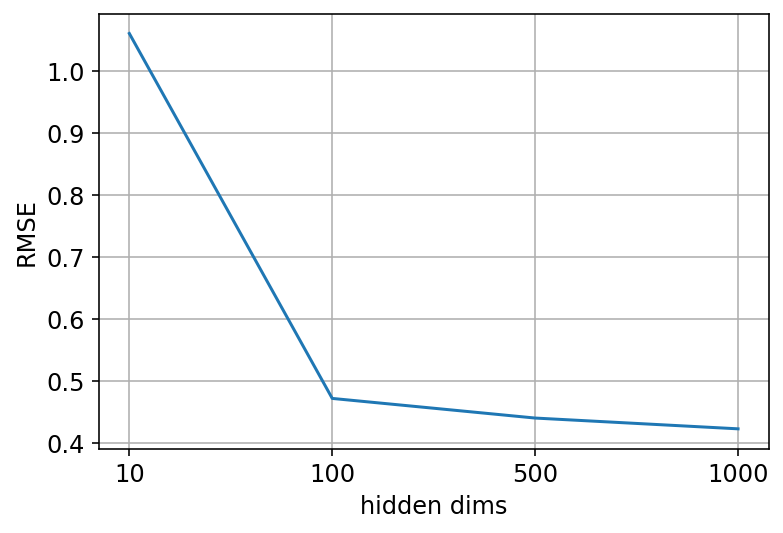

In [439]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(total_rmse_l)

ax.set_xticks(range(len(hidden_dims_l)))
ax.set_xticklabels(hidden_dims_l)

ax.set_xlabel('hidden dims'), ax.set_ylabel('RMSE')
ax.grid(True)
plt.show();

---
# CAE Improvements

&emsp; [ [**1.**](#1.-Intropolation) ] Interpolate high pressure values - increase precision at lower altitudes  
&emsp; [ [**2.**](#2.-Weighted-Loss) ] Apply more weight to high pressure values - modify loss function  
&emsp; [ [**3.**](#3.-RTMA-Surface) ] Ground surface level measurements - include RTMA data to improve on surface RAOB data  
&emsp; [ [**4.**](#4.-Independant-Model-Levels) ] Evaluate models that are trained at different levels - can the surface be modeled correctly without interference of higher altitudes

## 1. Intropolation

## 2. Weighted Loss

In [444]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

In [451]:
def weighted_mean_squared_error(y_true, y_pred, scale, lmda):
    """exponential decay weighted MSE"""
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)

    x = np.arange(diff.shape[1])
    y = lambda x: scale * np.exp(-lmda * x) + 1
    diff *= y(x)

    return K.mean(diff, axis=-1)

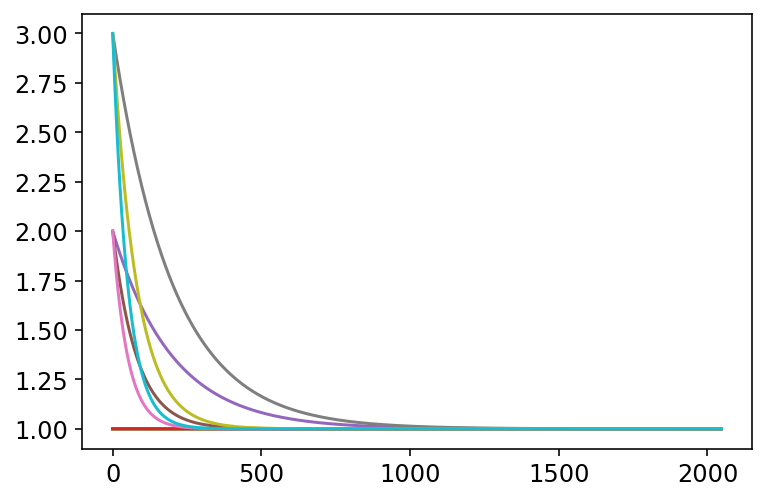

In [515]:
x = np.arange(Xtest.shape[1])

scales = np.linspace(0, 2, 3)
lmdas = np.linspace(0.005, 0.02, 3)

product = list(itertools.product(scales, lmdas))
product.insert(0, (0., 0.))

for scale, lmda in product:
    y = lambda x: scale * np.exp(-lmda * x) + 1
    plt.plot(y(x));

In [516]:
loss_l = []
rmse_l = []
total_rmse_l = []

f = FloatProgress(min=0, max=(len(product)))
display(f)

for scale, lmda in product:
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(3, 1)]*4,
                                       Ttrain.shape[1], activation='relu',
                                       n_hidden_dims=512, seed=1234)

    nnet.train(Xtrain, Ttrain, 25, 256, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest], 
               loss_f=[lambda y_true,y_pred: weighted_mean_squared_error(y_true, y_pred, 
                                                                         scale=scale, lmda=lmda)])
    
    loss_l.append(nnet.history['val_loss'])
    
    Y = nnet.use(Xtest)
    rmse_l.append(np.sqrt((np.mean((Y - Ttest)**2, axis=0))))
    total_rmse_l.append(ml.rmse(Y, Ttest))
    
    f.value += 1

FloatProgress(value=0.0, max=10.0)

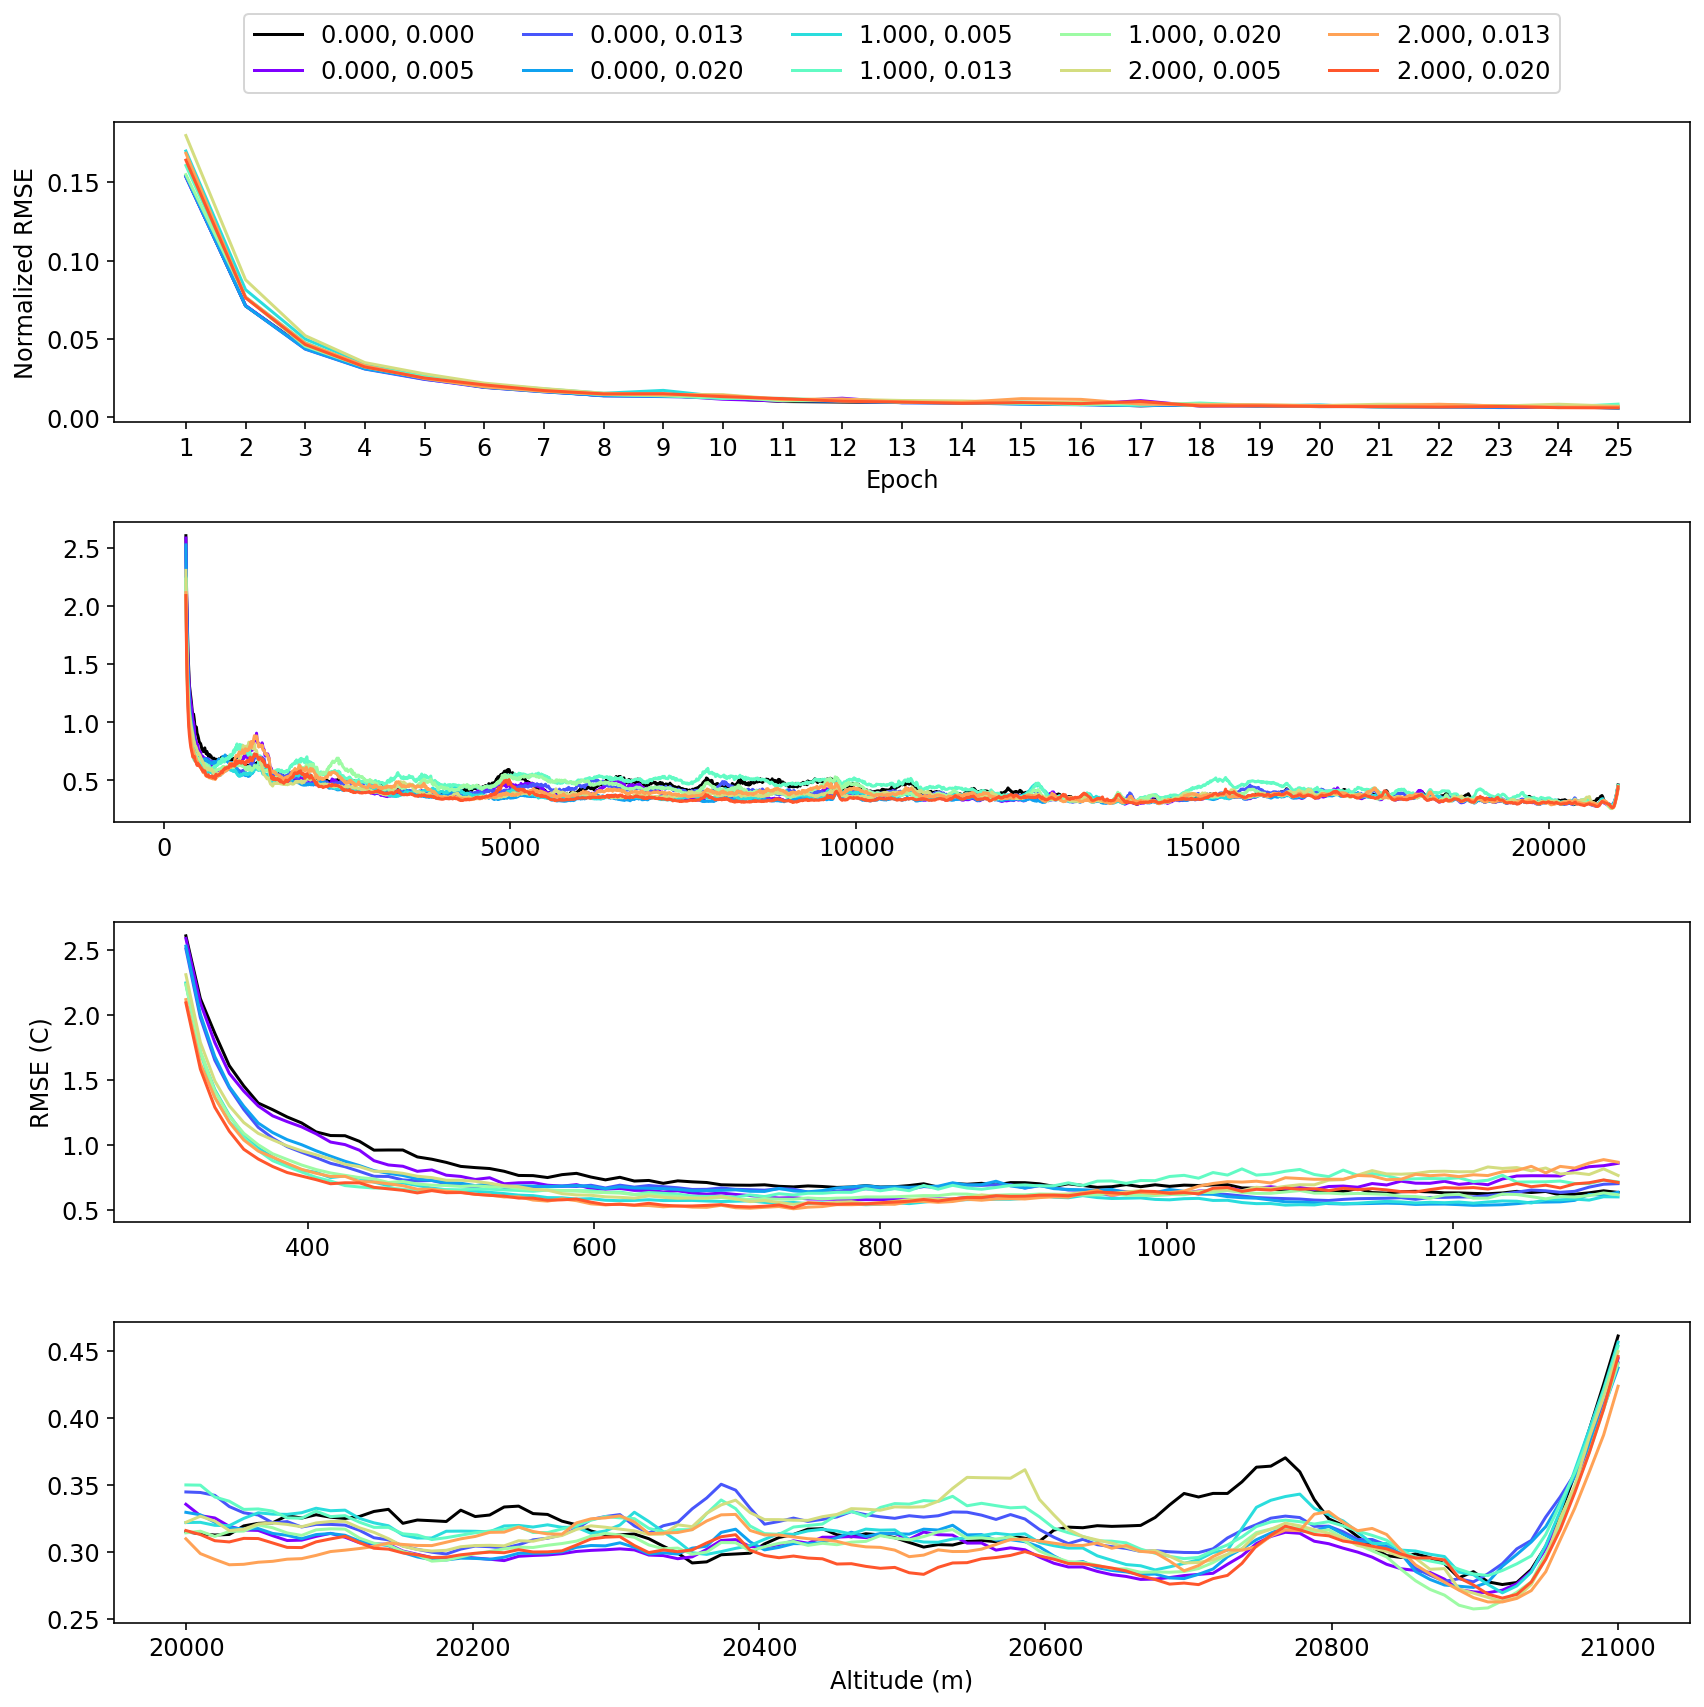

In [529]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
axs = axs.ravel()

color=iter(plt.cm.rainbow(np.linspace(0,1,len(product))))
alt_s = interpolated_profiles[0, 0, ALTITUDE]
altitude_intervals = np.linspace(alt_s, alt_el, SONDE_PROFILE_DIMS)
altitude_window = 100

i = 0
for scale, lmda in product:
    c = next(color) if i > 0 else 'k'
    axs[0].plot(loss_l[i], label=f'{scale:.3f}, {lmda:.3f}', color=c)
    axs[1].plot(altitude_intervals, rmse_l[i], color=c)
    axs[2].plot(altitude_intervals[:altitude_window], rmse_l[i][:altitude_window], color=c)
    axs[3].plot(altitude_intervals[-altitude_window:], rmse_l[i][-altitude_window:], color=c)
    i += 1

axs[0].set_xticks(range(len(loss_l[0])))
axs[0].set_xticklabels(range(1, len(loss_l[0]) + 1))
axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Normalized RMSE')
axs[3].set_xlabel('Altitude (m)'); axs[2].set_ylabel('RMSE (C)');

axs.flatten()[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5)
fig.tight_layout();

In [530]:
results = []
i = 0
for scale, lmda in product:
    results.append({'scale': f'{scale:.2f}', 'lambda': f'{lmda:.2f}',
                    'min_loss': np.min(loss_l[i]), 'rmse': total_rmse_l[i]})
    i += 1
df = pd.DataFrame(results)
df

,scale,lambda,min_loss,rmse
0,0.00,0.00,0.006620,0.448979
1,0.00,0.01,0.006087,0.411960
2,0.00,0.01,0.006332,0.425939
3,0.00,0.02,0.005744,0.389641
4,1.00,0.01,0.006534,0.395976
5,1.00,0.01,0.006510,0.477862
6,1.00,0.02,0.006314,0.434685
7,2.00,0.01,0.007165,0.405711
8,2.00,0.01,0.006557,0.415895
9,2.00,0.02,0.006110,0.387169


In [531]:
df.sort_values('rmse')

,scale,lambda,min_loss,rmse
9,2.00,0.02,0.006110,0.387169
3,0.00,0.02,0.005744,0.389641
4,1.00,0.01,0.006534,0.395976
7,2.00,0.01,0.007165,0.405711
1,0.00,0.01,0.006087,0.411960
8,2.00,0.01,0.006557,0.415895
2,0.00,0.01,0.006332,0.425939
6,1.00,0.02,0.006314,0.434685
0,0.00,0.00,0.006620,0.448979
5,1.00,0.01,0.006510,0.477862


## 3. RTMA Surface

## 4. Independant Model Levels

---
# Additional

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))